# DNV overrepresentation in network proximity to high confidence genes

- First run network propagation from each high confidence set, on each interactome (use netprop_zscore.py  - we ran it on AWS).  Requires graphs in gpickle format, and high confidence gene sets.

-------------------

Author: Brin Rosenthal (sbrosenthal@ucsd.edu)

-------------------
Update 4/28/20: more cleanup

Update 7/3/19: to remove extraneous code, add comments, and clarify

Update 4/11/19: removed patients with DNVs in HC genes from enrichment.  Did not affect the results

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import pandas as pd
import random


# latex rendering of text in graphs
import matplotlib as mpl
mpl.rc('text', usetex = False)
mpl.rc('font', family = 'serif')

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

sns.set_style('white')

import sys

% matplotlib inline

# for better labeling
import adjustText

# Load ASD, CHD genesets

ASD HC genes come from table 4 in http://www.cell.com/neuron/fulltext/S0896-6273(15)00773-4 

In [2]:
# ------- ASD HC genes -------

ASD_HC = pd.read_csv('../../data/ASD_HC.txt',names=['HC_genes'])

ASD_HC = ASD_HC['HC_genes'].tolist()
len(ASD_HC)



65

In [3]:
# ------- High confidence CHD genes -------

# Load congenital heart defect recurring DNVs (from http://science.sciencemag.org/content/sci/350/6265/1262.full.pdf)

CHD_seed_type='CHD_full' # can be 'CHD_withNDD', 'CHD_full', or 'CHD_only'


if CHD_seed_type=='CHD_full':
    # new HC genes:
    CHD_HC = pd.read_csv('../../data/CHD_HC_new.txt',names=['HC_genes'])
elif CHD_seed_type=='CHD_withNDD':
    CHD_HC = pd.read_csv('../../data/CHD_withNDD_HC_new.txt',names=['HC_genes'])
elif CHD_seed_type=='CHD_only':
    CHD_HC = pd.read_csv('../../data/CHD_only_HC_new.txt',names=['HC_genes'])

CHD_HC = CHD_HC['HC_genes'].tolist()
len(CHD_HC)

66

In [4]:
# Some gene symbols in the data were out of date (not consistent with networks) -- load mapping
map_old_new = pd.read_csv('../../data/ASD_EPI_CHD_HC_and_DNVs_symbol_gene_description.txt',sep='\t')
map_old_new.index=map_old_new['original_symbol']
map_old_new = map_old_new['symbol']
map_old_new.head()

original_symbol
A2M          A2M
A2ML1      A2ML1
AASS        AASS
ABCA1      ABCA1
ABCA13    ABCA13
Name: symbol, dtype: object

In [5]:
# Load all NDD DNVs (from 2015 CHD paper), extract SSC DNVs (autism)
NDD_df = pd.read_excel('../../data/CHD_NDD_databases/homsy_database_S08.xlsx',skiprows=1)

# ------------ Update 4/11 ------------
# Exclude patients with variants in the HC genes (Trey's comment)
NDD_df = NDD_df[~NDD_df['Gene'].isin(ASD_HC+CHD_HC)]
# ------------------------------------

ASD_DNV = NDD_df[NDD_df['Study']=='SSC']
print('number patients with a damaging ASD DNV (not in seed gene set):')
print(len(ASD_DNV))
ASD_DNV_VC = ASD_DNV['Gene'].value_counts() # count recurrences
ASD_DNV = list(np.unique(ASD_DNV['Gene'].tolist()))


print('number damaging ASD DNV (in patients which also have no seed gene variants):')
print(len(map_old_new.loc[ASD_DNV].dropna()))
ASD_DNV = map_old_new.loc[ASD_DNV].tolist()




print(ASD_DNV[0:10])
NDD_df.head()


number patients with a damaging ASD DNV (not in seed gene set):
630
number damaging ASD DNV (in patients which also have no seed gene variants):
592
['A2ML1', 'AASS', 'ABCA1', 'ABCA13', 'ABCA7', 'ABCB9', 'ABCG1', 'ABI2', 'ABL1', 'ABL2']


,Study,CHR,POS,REF,ALT,Proband ID,Class,Class (2),Gene,Ensembl Gene ID,AA1,AA2,dbNSFP Meta-SVM Rankscore
0,ASC,1,897739,T,C,09C87513,missense,D-mis,KLHL17,ENSG00000187961,L,P,0.87685
1,SSC,1,1222518,C,A,11563.p1,nonsense,lof,SCNN1D,ENSG00000162572,NaN,NaN,NaN
2,ASC,1,2234766,C,T,08C78919,nonsense,lof,SKI,ENSG00000157933,NaN,NaN,NaN
3,SSC,1,3519049,AC,A,14075.p1,frameshift,lof,MEGF6,ENSG00000162591,NaN,NaN,NaN
4,SSC,1,11205057,T,C,11104.p1,missense,D-mis,MTOR,ENSG00000198793,M,V,0.83852


In [6]:
print(sum(ASD_DNV_VC>1)) # number recurrent ASD -- no seeds
print(np.intersect1d(ASD_DNV_VC[ASD_DNV_VC>1].index.tolist(),ASD_HC)) # make sure there are no seeds in the data

32
[]


In [7]:
# Load all CHD DNVs (from 2017 paper)

CHD_DNV_df = pd.read_excel('../../data/CHD_databases_2017_paper/ng.3970-S3.xlsx',sheetname='S9',skiprows=1)
CHD_DNV_df.index=CHD_DNV_df['Blinded ID']

# exclude patients which have variants in HC genes -- from Trey's comment April 2019
print(len(CHD_DNV_df))
CHD_DNV_df = CHD_DNV_df[~CHD_DNV_df['Gene'].isin(ASD_HC+CHD_HC)]
print(len(CHD_DNV_df))

# apply the same filtering as for old data
CHD_DNV = CHD_DNV_df[(CHD_DNV_df['Variant_Class']!='syn')*(CHD_DNV_df['Variant_Class']!='mis')]
print('number damaging CHD DNVs:')
print(len(CHD_DNV))

CHD_DNV_VC = CHD_DNV['Gene'].value_counts() # count recurrences-- should be 0 because we removed them
print('\nnumber recurrent damaging CHD DNVs:')
print(sum(CHD_DNV_VC>1))

DNV_withNDD = CHD_DNV[CHD_DNV['NDD']=='Yes']
print('\nnumber damaging CHD DNVs with NDD:')
print(len(DNV_withNDD)) # number of patients
DNV_withNDD = DNV_withNDD['Gene'].unique().tolist()
print('\nnumber damaging unique CHD DNVs with NDD:')
print(len(DNV_withNDD)) # number of genes

DNV_noNDD = CHD_DNV[CHD_DNV['NDD']=='No']
DNV_noNDD = DNV_noNDD['Gene'].unique().tolist()
print('\nnumber damaging CHD DNVs without NDD:')
print(len(DNV_noNDD))


/Users/brinrosenthal/anaconda3/envs/ipykernel_py2/lib/python2.7/site-packages/pandas/util/_decorators.py:188: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  return func(*args, **kwargs)


2990
2760
number damaging CHD DNVs:
629

number recurrent damaging CHD DNVs:
0

number damaging CHD DNVs with NDD:
155

number damaging unique CHD DNVs with NDD:
155

number damaging CHD DNVs without NDD:
270


/Users/brinrosenthal/anaconda3/envs/ipykernel_py2/lib/python2.7/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


In [8]:
print(len(CHD_DNV_df['Blinded ID'].unique())) # num in CHD cohort
print(sum(CHD_DNV_df['NDD']=='Yes'))

1700
574


# Load the control DNVs

In [9]:
# Same in new version 

# Load all Control DNVs (from Database S3 in http://science.sciencemag.org/content/sci/350/6265/1262.full.pdf)
ctrl_DNV_df = pd.read_excel('../../data/CHD_NDD_databases/homsy_database_S03.xlsx',skiprows=1)
# exclude synonymous and non-damaging missense
ctrl_DNV = ctrl_DNV_df[(ctrl_DNV_df['Variant Class']!='Synonymous')*(ctrl_DNV_df['Variant Class']!='Missense')] 
#CHD_DNV = CHD_DNV_df[(CHD_DNV_df['Variant Class']!='Synonymous')] 
ctrl_DNV_VC = ctrl_DNV['Gene'].value_counts() # count recurrences
#CHD_DNV = CHD_DNV_df
ctrl_DNV = list(np.unique(ctrl_DNV['Gene'].tolist()))
ctrl_DNV_df.index=ctrl_DNV_df['Blinded ID']
print('number control DNVs:')
print(len(ctrl_DNV))
#print(len(map_old_new.loc[ctrl_DNV].dropna()))
#ctrl_DNV = map_old_new.loc[ctrl_DNV].tolist()
ctrl_DNV_df.head()

number control DNVs:
193


,Blinded ID,CHROM,POS,REF,ALT,Gene,Ensembl Gene ID,Variant Class,AA Change,dbNSFP Meta-SVM Rankscore,Comments
Blinded ID,,,,,,,,,,,
11003.s1,11003.s1,1,202715044,G,C,KDM5B,ENSG00000117139,Nonsense,NaN,NaN,NaN
11003.s1,11003.s1,5,178139609,G,A,ZNF354A,ENSG00000169131,Nonsense,NaN,NaN,NaN
11003.s1,11003.s1,16,70819649,C,A,VAC14,ENSG00000103043,Missense,A127S,0.08066,NaN
11003.s1,11003.s1,X,48374469,C,T,PORCN,ENSG00000102312,Missense,R288W,0.65878,NaN
11008.s1,11008.s1,12,94769688,G,A,CCDC41,ENSG00000173588,Nonsense,NaN,NaN,NaN


# Define gene sets for rest of analysis

In [10]:
# pick out which gene sets to investigate
genes_ASD = ASD_HC
print('number ASD high confidence genes:')
print(len(genes_ASD))
genes_CHD = CHD_HC
print('\nnumber CHD high confidence genes:')
print(len(genes_CHD))

print('\nnumber shared high confidence genes')
print(len(np.intersect1d(ASD_HC,CHD_HC)))

number ASD high confidence genes:
65

number CHD high confidence genes:
66

number shared high confidence genes
5


# Load previously computed network prop z-scores, and define and load interactome

In [11]:
# load previously computed z-scores and focal interactome
import scipy

num_reps = 5000
focal_interactome='PCnet'
rand_method = 'degree_binning' # can be 'degree_binning' or 'degree_ks_test' (deprecated)

z_ASD = pd.read_csv('../z_score_results/new_CHD_cohort/z_ASD_'+str(num_reps)+'_reps'+focal_interactome+'_'+rand_method+'.tsv',
                sep='\t',names=['gene','zscore'],index_col='gene')
if CHD_seed_type=='CHD_full':
    z_CHD = pd.read_csv('../z_score_results/new_CHD_cohort/z_CHD_'+str(num_reps)+'_reps'+focal_interactome+'_'+rand_method+'.tsv',
                       sep='\t',names=['gene','zscore'],index_col='gene')
elif CHD_seed_type=='CHD_withNDD':
    z_CHD = pd.read_csv('../z_score_results/new_CHD_cohort/z_CHD_withNDD_'+str(num_reps)+'_reps'+focal_interactome+'_'+rand_method+'.tsv',
                       sep='\t',names=['gene','zscore'],index_col='gene')
elif CHD_seed_type=='CHD_only':
    z_CHD = pd.read_csv('../z_score_results/new_CHD_cohort/z_CHD_only_'+str(num_reps)+'_reps'+focal_interactome+'_'+rand_method+'.tsv',
                       sep='\t',names=['gene','zscore'],index_col='gene')



z_ASD = z_ASD['zscore'].copy()
z_CHD = z_CHD['zscore'].copy()


                    

    

In [12]:
# reload the focal interactome (used to have more options... now we just use PCnet)
if focal_interactome=='PCnet':
    Gint = nx.read_gpickle('/Users/brinrosenthal/Documents/CCBB_tickets_data/PCnet/G_PCnet.gpickle')
    


In [13]:
print('number edges in interactome:')
print(len(Gint.edges()))
print('\nnumber nodes in interactome')
print(len(Gint.nodes()))

number edges in interactome:
2724724

number nodes in interactome
19781


In [14]:
# load previously computed paired z-scores (computed on AWS during propagation)

z_ASD_CHD = pd.read_csv('../z_score_results/new_CHD_cohort/z_ASD_CHD'+str(num_reps)+'_reps'+focal_interactome+'_'+rand_method+'.tsv',
                    sep='\t',names=['gene','zscore'],index_col='gene')
z_ASD_CHD = z_ASD_CHD['zscore'].copy()


    

# Plot location of DNVs in single z-score distributions, calculate KS statistic between DNV z-scores and full z-scores

gene
MED13L    4.215628
PBRM1     4.207929
VPS13D    4.089686
PNPLA7    3.975127
SETD2     3.852171
Name: zscore, dtype: float64
Ks_2sampResult(statistic=0.18422387374400706, pvalue=1.8436699434456862e-17)
gene
VSIG1    7.312675
CNTN2    4.981746
RYR2     3.770345
ITPR3    3.681369
TRPC5    3.616511
Name: zscore, dtype: float64
Ks_2sampResult(statistic=0.16602458042985563, pvalue=3.4440900932548084e-15)


/Users/brinrosenthal/anaconda3/envs/ipykernel_py2/lib/python2.7/site-packages/ipykernel_launcher.py:8: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  
/Users/brinrosenthal/anaconda3/envs/ipykernel_py2/lib/python2.7/site-packages/ipykernel_launcher.py:13: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  del sys.path[0]
/Users/brinrosenthal/anaconda3/envs/ipykernel_py2/lib/python2.7/site-packages/ipykernel_launcher.py:25: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as

(0, 0.43)

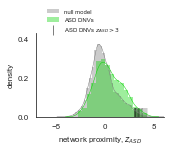

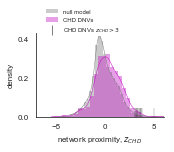

In [15]:
from scipy.stats import ks_2samp
plt.figure(figsize=(2.3,1.54))
# plt.figure()
sns.distplot(z_ASD.loc[np.setdiff1d(z_ASD.index.tolist(),ASD_HC)].dropna(),label='null model',color='#7E7E7E',kde=True,
            hist_kws={'histtype':'stepfilled','lw':0},
            kde_kws={'lw':.5})
ASD_DNV_no_seeds = list(np.setdiff1d(ASD_DNV,ASD_HC))
sns.distplot(z_ASD.loc[ASD_DNV_no_seeds].dropna(),color='#0ED50A',label='ASD DNVs',kde=True,hist_kws={'histtype':'stepfilled',
                                                                                                     'lw':0},
            kde_kws={'lw':.5})
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
top_DNVs = z_ASD.loc[ASD_DNV_no_seeds].dropna().sort_values(ascending=False)
top_DNVs = top_DNVs[top_DNVs>3]
sns.rugplot(z_ASD.loc[top_DNVs.index.tolist()],color='k',height=.1,lw=.2)
ax = plt.gca()
ax.scatter([], [], marker="|", linewidth=.5, color='k',s=100, label='ASD DNVs $z_{ASD}>3$') # so legend works
ax.set_xlabel('network proximity, $z_{ASD}$',fontsize=8)
ax.set_ylabel('density',fontsize=8)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.legend(loc='upper right',fontsize=6,frameon=False,
          bbox_to_anchor=(.7,1.35))
print(top_DNVs.head())
print(ks_2samp(z_ASD.loc[np.setdiff1d(z_ASD.index.tolist(),ASD_HC)],z_ASD.loc[ASD_DNV_no_seeds].dropna()))
plt.xlim([-7,6])
plt.ylim([0,.43])

# plt.savefig('../../manuscript/figures_1911/Figure2/z_ASD_dist.png',bbox_inches='tight',dpi=300)
# plt.savefig('../../manuscript/figures_1911/Figure2/z_ASD_dist.svg',bbox_inches='tight',dpi=300)
# plt.savefig('../../manuscript/figures_1911/Figure2/z_ASD_dist.pdf',bbox_inches='tight',dpi=300)

# plt.figure(figsize=(8,3))
plt.figure(figsize=(2.3,1.54))
sns.distplot(z_CHD.loc[np.setdiff1d(z_CHD.index.tolist(),CHD_HC)].dropna(),label='null model',color='#7E7E7E',kde=True,
            hist_kws={'histtype':'stepfilled','lw':0},
            kde_kws={'lw':.5})
CHD_DNV_no_seeds = list(np.setdiff1d(CHD_DNV,CHD_HC))
sns.distplot(z_CHD.loc[CHD_DNV_no_seeds].dropna(),color='#C410C4',label='CHD DNVs',kde=True,hist_kws={'histtype':'stepfilled',
                                                                                                     'lw':0},
            kde_kws={'lw':.5})
top_DNVs = z_CHD.loc[CHD_DNV_no_seeds].dropna().sort_values(ascending=False)
top_DNVs = top_DNVs[top_DNVs>3]
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
sns.rugplot(z_CHD.loc[top_DNVs.index.tolist()],color='k',height=.1,lw=.2)
ax = plt.gca()
ax.scatter([], [], marker="|", linewidth=.5, color='k',s=100, label='CHD DNVs $z_{CHD}>3$') # so legend works
ax.set_xlabel('network proximity, $z_{CHD}$',fontsize=8)
ax.set_ylabel('density',fontsize=8)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.legend(loc='upper right',fontsize=6,frameon=False,
          bbox_to_anchor=(.7, 1.35))
print(top_DNVs.head())
print(ks_2samp(z_CHD.loc[np.setdiff1d(z_CHD.index.tolist(),CHD_HC)],z_CHD.loc[CHD_DNV_no_seeds].dropna()))
plt.xlim([-7,6])
plt.ylim([0,.43])

# plt.savefig('../../manuscript/figures_1911/Figure2/z_CHD_dist.png',bbox_inches='tight',dpi=300)
# plt.savefig('../../manuscript/figures_1911/Figure2/z_CHD_dist.svg',bbox_inches='tight',dpi=300)
# plt.savefig('../../manuscript/figures_1911/Figure2/z_CHD_dist.pdf',bbox_inches='tight',dpi=300)


# Enrichment of SFARI genes in z_ASD

Check if SFARI genes have higher than expected z-scores

In [16]:
z_ASD.sort_values(ascending=False).head()

gene
RANBP17    51.905036
MFRP       33.376204
TRIP12     21.704553
ILF2       20.819412
NAA15      18.901197
Name: zscore, dtype: float64

In [17]:
# ASD enrichment for SFARI genes 
# scoring criteria: https://gene.sfari.org/about-gene-scoring/criteria/
zthresh = 3

sfari_genes = pd.read_csv('../../data/SFARI/SFARI-Gene_genes_export03-03-2018.csv',index_col='gene-symbol')
sfari_45S =sfari_genes[(sfari_genes['syndromic']==1)|(sfari_genes['gene-score']<=2.0)]
sfari_genes = sfari_45S.index.tolist()

sfari_genes_no_seeds = np.setdiff1d(sfari_genes,ASD_HC)
sfari_genes_no_seeds = np.intersect1d(sfari_genes_no_seeds,Gint.nodes()) # only keep genes in graph


# ASD z-scores
z_thresh=2
z_ASD_g1 = z_ASD.drop(list(np.intersect1d(z_ASD.index,ASD_HC))) # don't include seeds
z_ASD_g1 = z_ASD_g1[z_ASD_g1>zthresh].index.tolist()


ASD_g1 = np.intersect1d(sfari_genes_no_seeds,z_ASD_g1)

print(len(ASD_g1))
print(len(sfari_genes_no_seeds))
print(len(z_ASD_g1))
print(len(z_ASD))

k=len(ASD_g1)
n=len(sfari_genes_no_seeds)
N = len(z_ASD_g1)
M = len(z_ASD)

ASD_enrichemnt = scipy.stats.hypergeom.sf(k,M,n,N)

print('SFARI gene enrichment in ASD = ' + str(scipy.stats.hypergeom.sf(k,M,n,N)))

19
140
418
19781
SFARI gene enrichment in ASD = 1.623233531492863e-11


# How many DNVs are found in zscore > 3? ASD, CHD

In [18]:
def calc_enrichment(z,zthresh,DNV_list):
    '''
    Helper function to calculate hypergeometric stats
    '''
    z_Gthresh = z[z>zthresh].index.tolist()
    genes_Gthresh = np.intersect1d(DNV_list,z_Gthresh)

    print(len(genes_Gthresh))
    print(len(DNV_list))
    print(len(z_Gthresh))
    print(len(z))

    M = len(z)
    n=len(DNV_list)
    N = len(z_Gthresh)
    k=len(genes_Gthresh)

    p_hyper = scipy.stats.hypergeom.sf(k,M,n,N)
        
    # calculate expected mean and std given M,n,N
    exp_mean = scipy.stats.hypergeom.mean(M,n,N)
    exp_std = scipy.stats.hypergeom.std(M,n,N)
    
    return genes_Gthresh,p_hyper,exp_mean,exp_std

27
589
412
19655
ASD enrichment = 5.315658959413388e-05
15
636
242
19655
CHD enrichment = 0.005630656292253014


(0, 30)

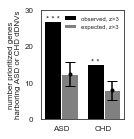

In [19]:
z_thresh = 3.0

# ---------------------------------------------------------------------------
# single ASD z-scores

z_ASD_noseeds = z_ASD.drop(list(np.intersect1d(z_ASD.index,CHD_HC+ASD_HC)))
ASD_DNV_in_graph = list(np.intersect1d(ASD_DNV,Gint.nodes()))
ASD_DNV_noseeds = list(np.setdiff1d(ASD_DNV_in_graph,ASD_HC))
ASD_g1,ASD_p,exp_ASD_mean,exp_ASD_std=calc_enrichment(z_ASD_noseeds,z_thresh,ASD_DNV_noseeds)
print('ASD enrichment = ' + str(ASD_p))


# ---------------------------------------------------------------------------
# single CHD z-scores

z_CHD_noseeds = z_CHD.drop(list(np.intersect1d(z_CHD.index,CHD_HC+ASD_HC)))
CHD_DNV_in_graph = list(np.intersect1d(CHD_DNV,Gint.nodes()))
CHD_DNV_noseeds = list(np.setdiff1d(CHD_DNV_in_graph,CHD_HC))
CHD_g1,CHD_p,exp_CHD_mean,exp_CHD_std=calc_enrichment(z_CHD_noseeds,z_thresh,CHD_DNV_noseeds)
print('CHD enrichment = ' + str(CHD_p))


# -------------------------------------------
# plot the results
# plt.figure(figsize=(3,4))
plt.figure(figsize=(1.5,2))

recovered_list = [len(ASD_g1),len(CHD_g1)]
pval_list = [ASD_p,CHD_p]

plt.bar([0,1],recovered_list,width=.4,color='k',label='observed, z>3')
plt.bar([0.4,1.4],[exp_ASD_mean,exp_CHD_mean],width=.4,color='gray',
       label='expected, z>3')
plt.errorbar([0.4,1.4],[exp_ASD_mean,exp_CHD_mean],
             [exp_ASD_std,exp_CHD_std],fmt='k.',ecolor='k',capsize=5.0)

# add stars for significance
for i in [0,1]:
    star_height = recovered_list[i]+max(recovered_list)*0.01 # add 5% of max to value
    if (pval_list[i] < 0.05) & (pval_list[i]>0.01):
        plt.annotate('*',(i,star_height),fontsize=8,ha='center')
    elif (pval_list[i] <= 0.01) & (pval_list[i]>0.001):
#         plt.annotate('*',[i-.05,i+.05],[star_height]*2,fontsize=6)
        plt.annotate('* *',(i,star_height),fontsize=8,ha='center')
    elif (pval_list[i] <= 0.001):
#         plt.annotate('*',[i-.1,i,i+.1],[star_height]*3,fontsize=6)
        plt.annotate('* * *',(i,star_height),fontsize=8,ha='center')
                


plt.legend(loc='best',fontsize=6,frameon=False)
# plt.legend(loc='upper right',fontsize=6,frameon=False,
#           bbox_to_anchor=(1.3, 1.05))
plt.xticks([0.2,1.2],['ASD','CHD'],fontsize=8)
plt.yticks(fontsize=8)
plt.ylabel('number prioritized genes\nharboring ASD or CHD dDNVs',fontsize=8)
plt.ylim([0,30])

# plt.savefig('../../manuscript/figures_1911/Figure2/z_score_num_recovered_DNVs_single_3.0.png',
#            dpi=300,bbox_inches='tight')
# plt.savefig('../../manuscript/figures_1911/Figure2/z_score_num_recovered_DNVs_single_3.0.pdf',
#            dpi=300,bbox_inches='tight')
# plt.savefig('../../manuscript/figures_1911/Figure2/z_score_num_recovered_DNVs_single_3.0.svg',
#            dpi=300,bbox_inches='tight')



6
192
412
19655
ASD enrichment = 0.11001081232453629
2
192
242
19655
CHD enrichment = 0.4218996360763009


Text(0,0.5,'number recovered control DNVs')

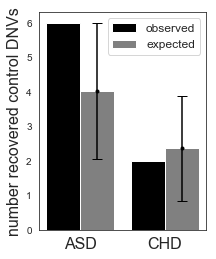

In [21]:
# how many Control DNVs are recovered by ASD, EPI and CHD, respectively

z_thresh = 3

# ---------------------------------------------------------------------------
# control DNVs in single ASD z-scores

z_ASD_noseeds = z_ASD.drop(list(np.intersect1d(z_ASD.index,CHD_HC+ASD_HC)))
ctrl_DNV_in_graph = list(np.intersect1d(ctrl_DNV,Gint.nodes()))
ctrl_DNV_noseeds = ctrl_DNV_in_graph
ASD_g1,ASD_p,exp_ASD_mean,exp_ASD_std=calc_enrichment(z_ASD_noseeds,z_thresh,ctrl_DNV_noseeds)
print('ASD enrichment = ' + str(ASD_p))

# ---------------------------------------------------------------------------
# control DNVs in single CHD z-scores

z_CHD_noseeds = z_CHD.drop(list(np.intersect1d(z_CHD.index,CHD_HC+ASD_HC)))
CHD_g1,CHD_p,exp_CHD_mean,exp_CHD_std=calc_enrichment(z_CHD_noseeds,z_thresh,ctrl_DNV_noseeds)
print('CHD enrichment = ' + str(CHD_p))

# -------------------------------------------
# plot the results
plt.figure(figsize=(3,4))

recovered_list = [len(ASD_g1),len(CHD_g1)]
pval_list = [ASD_p,CHD_p]

plt.bar([0,1],recovered_list,width=.4,color='k',label='observed')
plt.bar([0.4,1.4],[exp_ASD_mean,exp_CHD_mean],width=.4,color='gray',
       label='expected')
plt.errorbar([0.4,1.4],[exp_ASD_mean,exp_CHD_mean],
             [exp_ASD_std,exp_CHD_std],fmt='k.',ecolor='k',capsize=5.0)

# add stars for significance
for i in [0,1]:
    star_height = recovered_list[i]+max(recovered_list)*0.05 # add 5% of max to value
    if (pval_list[i] < 0.05) & (pval_list[i]>0.01):
        plt.plot([i],[star_height],'k*')
    elif (pval_list[i] <= 0.01) & (pval_list[i]>0.001):
        plt.plot([i-.05,i+.05],[star_height]*2,'k*')
    elif (pval_list[i] <= 0.001):
        plt.plot([i-.1,i,i+.1],[star_height]*3,'k*')
                


plt.legend(loc='best',fontsize=12)
plt.xticks([0.2,1.2],['ASD','CHD'],fontsize=16)
plt.ylabel('number recovered control DNVs',fontsize=16)


# plt.savefig('../../manuscript/figures_1911/Supplement/z_score_num_recovered_DNVs_single_'+str(z_thresh)+'_ctrl.png',
#           dpi=300,bbox_inches='tight')

In [22]:
z_ASD.sort_values(ascending=False,inplace=True)
z_CHD.sort_values(ascending=False,inplace=True)



In [23]:
print('max ASD_HC zscore:')
print(z_ASD.loc[ASD_HC].max())
print('\nmax CHD_HC zscore:')
print(z_CHD.loc[CHD_HC].max())

max ASD_HC zscore:
51.9050361869

max CHD_HC zscore:
34.857337174899996


# Plot the shared-phenotype DNVs in combined z-score space

## CHD-ASD

In [24]:

combine_after_zscore=True # whether to use the score combined before or after z-score calculation
include_seeds=False # plot with or without seeds

z_ASD_abs = z_ASD.copy(deep=True)
ASD_HC_in_G = list(np.intersect1d(ASD_HC,Gint.nodes()))


z_CHD_abs = z_CHD.copy(deep=True)
CHD_HC_in_G = list(np.intersect1d(CHD_HC,Gint.nodes()))



if include_seeds==False: # remove seeds if false
    z_ASD_abs.loc[ASD_HC_in_G]=np.nan # remove the seeds
    z_CHD_abs.loc[CHD_HC_in_G]=np.nan # remove the seeds



In [25]:
# use diff btwn max and min to set axes labels
print(z_ASD_abs.max()-z_ASD_abs.min())

print(z_CHD_abs.max()-z_CHD_abs.min())


13.65848615693
14.22708069593


-4.34949947011
-4.70643282787


/Users/brinrosenthal/anaconda3/envs/ipykernel_py2/lib/python2.7/site-packages/ipykernel_launcher.py:72: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/Users/brinrosenthal/anaconda3/envs/ipykernel_py2/lib/python2.7/site-packages/ipykernel_launcher.py:75: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


../../manuscript/figures_1911/Figure2/ASD_CHD_zscore_dots__no_seeds_combine_after_zscore


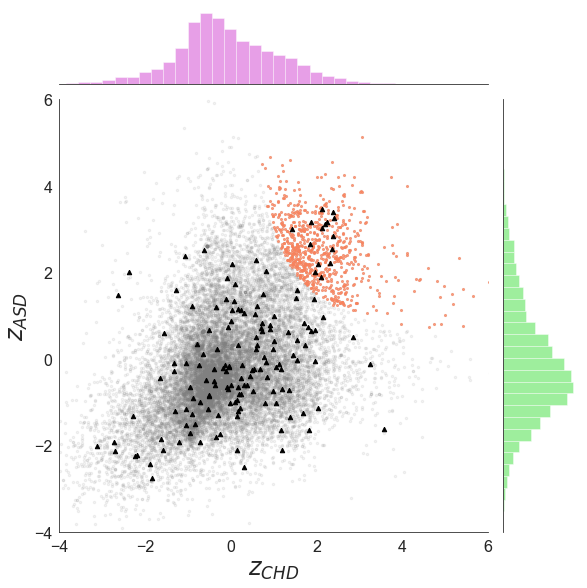

In [26]:


# -------------------- Plot on the paired disorder axes ----------------------

print(z_ASD.min())
print(z_CHD.min())
D1name='ASD'
D2name='CHD'

genes_D1 = ASD_HC
genes_D2 = CHD_HC

idx_temp = z_CHD_abs.index.tolist()

z_ASD_abs = z_ASD_abs.loc[idx_temp]

# j = sns.jointplot(z_CHD_abs,z_ASD_abs,gridsize=35,kind='hex',height=10)
j = sns.jointplot(z_CHD_abs,z_ASD_abs,kind='scatter',height=8,alpha=.1,joint_kws={'s':6,'color':'gray'},marginal_kws={'color':'white'})
# set the colors of the marginal distributions to match other figs
plt.sca(j.ax_marg_x)
sns.distplot(z_CHD_abs.dropna().tolist(),color='#C410C4',kde=False)
plt.sca(j.ax_marg_y)
sns.distplot(z_ASD_abs.dropna().tolist(),color='#0ED50A',kde=False,vertical=True)

# plt.ylim([0,.4])

plt.sca(j.ax_joint)
j.ax_joint.set_xlabel('$z_{CHD}$',fontsize=24)
j.ax_joint.set_ylabel('$z_{ASD}$',fontsize=24)

zthresh=3

if combine_after_zscore == True:
    z_score_both = z_CHD_abs*z_ASD_abs*(z_CHD_abs>0)*(z_ASD_abs>0)
else:
    z_score_both = z_ASD_CHD 

high_z_genes = z_score_both[z_score_both>zthresh].index.tolist()
plt.plot((z_CHD_abs[z_score_both>zthresh]),(z_ASD_abs[z_score_both>zthresh]),'.',color='#F9825C',
         ms=4,alpha=.7)

# higher_z_genes = z_score_both[z_score_both>4].index.tolist()
# plt.plot((z_CHD_abs[z_score_both>4]),(z_ASD_abs[z_score_both>4]),'.',color='red',
#          ms=4,alpha=.5)


only_D2=np.setdiff1d(genes_D2,genes_D1)
only_D1 = np.setdiff1d(genes_D1,genes_D2)
D1_and_D2 = np.intersect1d(genes_D1,genes_D2)

# draw the seed nodes with borders
only_D2_blue = list(np.intersect1d(only_D2,z_score_both[z_score_both<zthresh].index.tolist()))
only_D2_orange = list(np.intersect1d(only_D2,z_score_both[z_score_both>zthresh].index.tolist()))

only_D1_blue = list(np.intersect1d(only_D1,z_score_both[z_score_both<zthresh].index.tolist()))
only_D1_orange = list(np.intersect1d(only_D1,z_score_both[z_score_both>zthresh].index.tolist()))

plt.plot((z_CHD_abs.loc[only_D2_orange]),(z_ASD_abs.loc[only_D2_orange]),'o',ms=6,mec='#C815F0',mew=.7,
        fillstyle='full',mfc='#F9825C')
plt.plot((z_CHD_abs.loc[only_D2_blue]),(z_ASD_abs.loc[only_D2_blue]),'o',ms=6,mec='#C815F0',mew=.7,
        fillstyle='full',mfc='#508CC8')
plt.plot((z_CHD_abs.loc[only_D1_blue]),(z_ASD_abs.loc[only_D1_blue]),'o',ms=6,mec='#55CCCA',mew=.7,
        fillstyle='full',mfc='#508CC8')
plt.plot((z_CHD_abs.loc[only_D1_orange]),(z_ASD_abs.loc[only_D1_orange]),'o',ms=6,mec='#55CCCA',mew=.7,
        fillstyle='full',mfc='#F9825C')
plt.plot((z_CHD_abs.loc[D1_and_D2]),(z_ASD_abs.loc[D1_and_D2]),'o',ms=6,mec='black',mew=.7,
        fillstyle='full',mfc='#F9825C')



# overlay the DNVs with NDDs
plt.plot(z_CHD_abs.loc[DNV_withNDD],z_ASD_abs.loc[DNV_withNDD],'k^',ms=4.5)

#annotate top DNVs -- add 10 so we don't have to deal with multiplying negative numbers
DNVs_top_10 = ((z_ASD_abs.loc[DNV_withNDD]+10)*(z_CHD_abs.loc[DNV_withNDD]+10)).dropna().sort_values(ascending=False).head(16).index.tolist()
# if include_seeds==False: # only print labels if not including seeds
#     for d in DNVs_top_10:
#             print(d)
# #             plt.annotate(d,xy=(z_CHD_abs.loc[d]-.03,z_ASD_abs.loc[d]-.01),
# #                        fontsize=9,rotation=0,horizontalalignment='right')
#     texts_tmp = [plt.text(z_CHD_abs.loc[d],z_ASD_abs.loc[d],d) for d in DNVs_top_10]
#     adjustText.adjust_text(texts_tmp,avoid_points=False,expand_text=(1.05,1.05),lim=10)

ax=plt.gca()

if include_seeds==False: # only set axes limits if not including seeds
    plt.xlim([-4,6])
    plt.ylim([-4,6])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

#ax.set_yscale('log')
#ax.set_xscale('log')

# fname_string = '../../manuscript/figures_1911/'+focal_interactome+'/ASD_CHD_zscore_dots_'
fname_string = '../../manuscript/figures_1911/Figure2/ASD_CHD_zscore_dots_'
if include_seeds==True:
    fname_string+='_with_seeds'
    
elif include_seeds==False:
    fname_string+='_no_seeds'
    
if combine_after_zscore==True:
    fname_string+='_combine_after_zscore'
elif combine_after_zscore==False:
    fname_string+='_combine_before_zscore'
    
print(fname_string)
# plt.savefig(fname_string+'.png',dpi=300,bbox_inches='tight')
# plt.savefig(fname_string+'.svg',dpi=300,bbox_inches='tight')
# plt.savefig(fname_string+'.pdf',dpi=300,bbox_inches='tight')

In [27]:
# number high scoring genes
len(high_z_genes)

764

# Calculate how many CHD-NDD DNVs are recovered above z = zthresh, in z_ASD, z_CHD, and z_ASD_CHD

And compare to number expected given hypergeometric distribution

7
155
412
19655
ASD enrichment = 0.016663258298861512
0
155
69
19655
ASD enrichment = 0.42145804284110766
3
155
242
19655
CHD enrichment = 0.1248217683401912
1
155
71
19655
CHD enrichment = 0.1080633856520683
15
155
764
19655
ASD-CHD enrichment = 0.00036114001181785255
13
155
478
19655
ASD-CHD enrichment = 2.6584169651704582e-05


(0, 17)

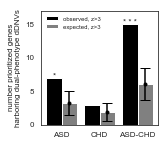

In [28]:


zthresh1 = 3 # combined zthreshold
zthresh2=4 # more stringent threshold

DNV_noseeds = list(np.setdiff1d(DNV_withNDD,CHD_HC+ASD_HC))

# ---------------------------------------------------------------------------
# shared phenotype DNVs enriched in single ASD z-scores?
    
z_ASD_noseeds = z_ASD.drop(list(np.intersect1d(z_ASD.index,CHD_HC+ASD_HC)))
ASD_g1,ASD_p1,exp_ASD1_mean,exp_ASD1_std=calc_enrichment(z_ASD_noseeds,zthresh1,DNV_noseeds)
print('ASD enrichment = ' + str(ASD_p1))

ASD_g2,ASD_p2,exp_ASD2_mean,exp_ASD2_std=calc_enrichment(z_ASD_noseeds,zthresh2,DNV_noseeds)
print('ASD enrichment = ' + str(ASD_p2))
# ---------------------------------------------------------------------------
# shared phenotype DNVs enriched in single CHD z-scores?

    
z_CHD_noseeds = z_CHD.drop(list(np.intersect1d(z_CHD.index,CHD_HC+ASD_HC)))
CHD_g1,CHD_p1,exp_CHD1_mean,exp_CHD1_std=calc_enrichment(z_CHD_noseeds,zthresh1,DNV_noseeds)
print('CHD enrichment = ' + str(CHD_p1))
  
CHD_g2,CHD_p2,exp_CHD2_mean,exp_CHD2_std=calc_enrichment(z_CHD_noseeds,zthresh2,DNV_noseeds)
print('CHD enrichment = ' + str(CHD_p2))
# ---------------------------------------------------------------------------
# shared phenotype DNVs enriched in combined ASD-CHD z-scores?

z_both = z_CHD*z_ASD*(z_CHD>0)*(z_ASD>0)
z_both_noseeds = z_both.drop(list(np.intersect1d(z_CHD.index,CHD_HC+ASD_HC)))
both_g1,both_p1,exp_both1_mean,exp_both1_std=calc_enrichment(z_both_noseeds,zthresh1,DNV_noseeds)
print('ASD-CHD enrichment = ' + str(both_p1))

both_g2,both_p2,exp_both2_mean,exp_both2_std=calc_enrichment(z_both_noseeds,zthresh2,DNV_noseeds)
print('ASD-CHD enrichment = ' + str(both_p2))

# -------------------------------------------
# plot the results
plt.figure(figsize=(2.1,2.1))

recovered_list1 = [len(ASD_g1),len(CHD_g1),len(both_g1)]
pval_list1 = [ASD_p1,CHD_p1,both_p1]
exp_list_mean1 = [exp_ASD1_mean,exp_CHD1_mean,exp_both1_mean]
exp_list_std1 = [exp_ASD1_std,exp_CHD1_std,exp_both1_std]
recovered_list2 = [len(ASD_g2),len(CHD_g2),len(both_g2)]
pval_list2 = [ASD_p2,CHD_p2,both_p2]
exp_list_mean2 = [exp_ASD2_mean,exp_CHD2_mean,exp_both2_mean]
exp_list_std2 = [exp_ASD2_std,exp_CHD2_std,exp_both2_std]

plt.bar([0,1,2],recovered_list1,width=.4,color='k',label='observed, z>3')
plt.bar([0.4,1.4,2.4],exp_list_mean1,width=.4,color='gray',
       label='expected, z>3')
plt.errorbar([0.4,1.4,2.4],exp_list_mean1,
             exp_list_std1,fmt='k.',ecolor='k',capsize=5.0)

# plt.bar([0.4,1.4,2.4],recovered_list2,width=.2,color='k',label='observed, z>4',hatch="//")
# plt.bar([0.6,1.6,2.6],exp_list_mean2,width=.2,color='gray',
#        label='expected, z>4',hatch="//")
# plt.errorbar([0.6,1.6,2.6],exp_list_mean2,
#              exp_list_std2,fmt='k.',ecolor='k',capsize=5.0)



# add stars for significance
for i in [0,1,2]:
    star_height = recovered_list1[i]+max(recovered_list1)*0 # add 5% of max to value
    if (pval_list1[i] < 0.05) & (pval_list1[i]>0.01):
        #plt.plot([i],[star_height],'k*')
        plt.annotate('*',(i,star_height),fontsize=8,ha='center')
    elif (pval_list1[i] <= 0.01) & (pval_list1[i]>0.001):
        #plt.plot([i-.05,i+.05],[star_height]*2,'k*')
        plt.annotate('* *',(i,star_height),fontsize=8,ha='center')
    elif (pval_list1[i] <= 0.001):
        #plt.plot([i-.1,i,i+.1],[star_height]*3,'k*')
        plt.annotate('* * *',(i,star_height),fontsize=8,ha='center')
        
# add stars for significance
# for i in [0,1,2]:
#     star_height = recovered_list2[i]+max(recovered_list2)*0.05 # add 5% of max to value
#     if (pval_list2[i] < 0.05) & (pval_list2[i]>0.01):
#         plt.plot([i]+.4,[star_height],'k*')
#     elif (pval_list2[i] <= 0.01) & (pval_list2[i]>0.001):
#         plt.plot([i-.05+.4,i+.05+4],[star_height]*2,'k*')
#     elif (pval_list2[i] <= 0.001):
#         plt.plot([i-.1+.4,i+.4,i+.1+.4],[star_height]*3,'k*')
        
plt.legend(loc='upper left',fontsize=6,ncol=1,frameon=False)
plt.xticks([0.2,1.2,2.2],['ASD','CHD','ASD-CHD'],fontsize=8)
plt.ylabel('number prioritized genes\nharboring dual-phenotype dDNVs',fontsize=8)
plt.yticks(fontsize=8)
plt.ylim([0,17])

# plt.ylim([-.5,20])

# ------------------------ if combined post-propagation ------------------------


# plt.savefig('../../manuscript/figures_1911/Figure2/z_score_num_recovered_DNVs_ASD-CHD_3combined_product_z3.pdf',
#            bbox_inches='tight',dpi=300)
# plt.savefig('../../manuscript/figures_1911/Figure2/z_score_num_recovered_DNVs_ASD-CHD_3combined_product_z3.png',
#            bbox_inches='tight',dpi=300)
# plt.savefig('../../manuscript/figures_1911/Figure2/z_score_num_recovered_DNVs_ASD-CHD_3combined_product_z3.svg',
#            bbox_inches='tight',dpi=300)

# ------------------------ if combined pre-propagation ------------------------
# plt.savefig('../../manuscript/figures_18_12/'+focal_interactome+'/z_score_num_recovered_DNVs_ASD-CHD_'+str(zthresh)+'combined_z.pdf',
#           dpi=300,bbox_inches='tight')

# ----------- plot the odds ratios -----------
# plt.figure(figsize=(5,5))
# recovered_list = [len(ASD_g1),len(CHD_g1),len(both_g1)]
# exp_list = [np.mean(exp_temp_ASD),np.mean(exp_temp_CHD),np.mean(exp_temp_both)]
# obs_div_exp = np.divide(recovered_list,exp_list)
# pval_list = [ASD_p,CHD_p,both_p]

# plt.bar([0,1,2],obs_div_exp,width=.4,color='k',label='observed')
# plt.ylabel('observed/expected',fontsize=16)